In [27]:
from bs4 import BeautifulSoup
import json
import psycopg2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import re
import requests
from tqdm import tqdm_notebook
%matplotlib inline

##### DB connection

In [99]:
con = psycopg2.connect(
    database="postgres",
    user="ds",
    password="cxXl5o",
    host="192.168.1.89",
    port="5432"
)

print("Database opened successfully")

Database opened successfully


##### Rollback (run if exception rises)

In [58]:
curs = con.cursor()
curs.execute("ROLLBACK")
con.commit()

##### Getting adresses

In [ ]:
cur = con.cursor()
cur.execute('''
SELECT DISTINCT "Точный_адрес" FROM public."Resident_old" WHERE "Город" = 'Москва'
''')

rows = cur.fetchall()

con.close()

##### DF from list of tuples

In [ ]:
df = pd.DataFrame(data=rows[:10], columns=['Adress_or_code', ]).dropna()
df.shape

##### Filling longitude and latitude (property)

In [ ]:
df['Longitude'] = df['Adress_or_code'].apply(adress_to_coord)[1]
df['Latitude'] = df['Adress_or_code'].apply(adress_to_coord)[0]

df = df.dropna()

In [ ]:
df.head(20)

##### Filling longitude and latitude (schools)
https://data.mos.ru/opendata/565

In [89]:
df_schools = pd.read_csv('Schools.csv', delimiter=';')[
    ['X', 'Y', 'name']]

df_schools['Longitude'] = df_schools['X']
df_schools['Latitude'] = df_schools['Y']
df_schools['Title'] = df_schools['name']

df_schools = df_schools.dropna().drop(columns=['X', 'Y', 'name'])

In [90]:
df_schools.head(20)

,Longitude,Latitude,Title
0,"37,205531","55,997156",Негосударственное образовательное учреждение с...
1,"37,20909","55,994797",Некоммерческое партнерство Международная школа...
2,"37,53295","55,730826",Государственное бюджетное образовательное учре...
3,"37,465808","55,662225",Государственное бюджетное образовательное учре...
4,"37,504038","55,703325",Государственное бюджетное образовательное учре...
5,"37,49003","55,696974",Государственное бюджетное образовательное учре...
6,"37,294653","55,614268",Государственное бюджетное образовательное учре...
7,"37,549365","55,746667",Государственное бюджетное образовательное учре...
8,"37,419794","55,71726",Государственное бюджетное образовательное учре...
9,"37,412784","55,756143",Государственное бюджетное образовательное учре...


##### Filling longitude and latitude (parks)
https://data.mos.ru/opendata/1465

In [115]:
df_parks = pd.read_json(
    'Parks.json', encoding='windows-1251')[['geoData', 'CommonName']]


def mean_lon_lat_parks(met):  # Park centers coordinates
    return df_parks['geoData'].apply(
        lambda ad: np.array(
            list(
                map(
                    lambda mean_ad: np.array(
                        np.array(
                            mean_ad
                        ).transpose()[met]).mean(), ad['coordinates']
                )
            )
        ).mean())


df_parks['Longitude'] = mean_lon_lat_parks(0)
df_parks['Latitude'] = mean_lon_lat_parks(1)
df_parks['Title'] = df_parks['CommonName']

df_parks = df_parks.dropna().drop(columns=['geoData', 'CommonName'])

<ipython-input-115-edc6e9e76947>:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  np.array(


In [116]:
df_parks.head(20)

,Longitude,Latitude,Title
0,37.556961,55.703453,Памятник садово-паркового искусства – «Парк Дв...
1,37.554454,55.611620,Природно-исторический парк «Битцевский лес»
2,37.410283,55.856753,Природно-исторический парк «Тушинский»
3,37.466570,55.650124,Ландшафтный заказник «Тропарёвский»
4,40.744281,52.701569,Природно-исторический парк «Кузьминки-Люблино»
5,37.198116,55.995615,Крюковский лесопарк Дунькин пруд
6,37.703203,55.617889,Природно-исторический парк «Царицыно»
7,37.640085,55.867179,Природно-исторический парк «Останкино»
8,37.798533,55.779619,Природно-исторический парк «Измайлово»
9,37.899147,55.720932,Природно-исторический парк «Косинский»


##### Filling longitude and latitude (kindergartens)
https://data.mos.ru/opendata/540

In [77]:
df_kindergartens = pd.read_csv('Kindergartens.csv', delimiter=';')[
    ['X', 'Y', 'name']]

df_kindergartens['Longitude'] = df_kindergartens['X']
df_kindergartens['Latitude'] = df_kindergartens['Y']
df_kindergartens['Title'] = df_kindergartens['name']

df_kindergartens = df_kindergartens.dropna().drop(columns=['X', 'Y', 'name'])

In [83]:
df_kindergartens.head(20)

,Longitude,Latitude,Title
0,"37,720928","55,781391",Государственное бюджетное образовательное учре...
1,"37,612196","55,708789",Государственное бюджетное образовательное учре...
2,"37,600259","55,776371",Государственное бюджетное образовательное учре...
3,"37,835497","55,769585",Государственное бюджетное образовательное учре...
4,"37,58253","55,766916",Государственное бюджетное образовательное учре...
5,"37,81607","55,809671",Государственное бюджетное образовательное учре...
6,"37,548766","55,694366",Государственное бюджетное образовательное учре...
7,"37,540116","55,644213",Негосударственное общеобразовательное учрежден...
8,"37,659687","55,681569",Государственное бюджетное образовательное учре...
9,"37,580377","55,743819",Государственное бюджетное образовательное учре...


##### Filling longitude and latitude (subways)
https://data.mos.ru/opendata/624

In [49]:
df_subways = pd.read_csv('Subways.csv', delimiter=';')[
    ['Longitude_WGS84', 'Latitude_WGS84', 'Name']]

df_subways['Longitude'] = df_subways['Longitude_WGS84']
df_subways['Latitude'] = df_subways['Latitude_WGS84']
df_subways['Title'] = df_subways['Name']

df_subways = df_subways.dropna().drop(
    columns=['Longitude_WGS84', 'Latitude_WGS84', 'Name'])

In [89]:
df_subways.head(20)

,Longitude,Latitude,Title
0,37.631677,55.757315,"Китай-город, вход-выход 5 в северный вестибюль"
1,37.631205,55.756855,"Китай-город, вход-выход 4 в северный вестибюль"
2,37.631951,55.757236,"Китай-город, вход-выход 6 в северный вестибюль"
3,37.633082,55.753098,"Китай-город, вход-выход 14 в южный вестибюль"
4,37.633559,55.753072,"Китай-город, вход-выход 12 в южный вестибюль"
5,37.634177,55.754134,"Китай-город, вход-выход 10 из южного вестибюля"
6,37.634966,55.754114,"Китай-город, вход-выход 9 в южный вестибюль"
7,37.629468,55.756640,"Китай-город, вход-выход 2 в северный вестибюль"
8,37.539238,55.655386,"Калужская, вход-выход 5 в южный вестибюль"
9,37.752643,55.660114,"Братиславская, вход-выход 5 в северный вестибюль"


##### Filling longitude and latitude (public transport stations)
https://data.mos.ru/opendata/60662

In [11]:
df_stations = pd.read_json(
    'PTStations.json', encoding='windows-1251')[['geoData', 'stop_name']]

df_stations['Longitude'] = df_stations['geoData'].apply(
    lambda lon: lon['coordinates'][0])
df_stations['Latitude'] = df_stations['geoData'].apply(
    lambda lat: lat['coordinates'][1])
df_stations['Title'] = df_stations['stop_name']

df_stations = df_stations.dropna().drop(columns=['geoData', 'stop_name'])

In [19]:
df_stations.head(20)

,Longitude,Latitude,Title
0,37.787726,55.792903,5-я Парковая ул.
1,37.793818,55.793014,7-я Парковая ул.
2,37.798824,55.793099,Метро «Первомайская»
3,37.819813,55.793439,15-я Парковая ул.
4,37.761697,55.786649,Главная ал.
5,37.686120,55.799492,Ул. Короленко
6,37.710031,55.795010,Преображенская пл.
7,37.657764,55.772328,Новорязанская ул.
8,37.728501,55.799295,Халтуринская ул.
9,37.664550,55.678230,Метро «Коломенская»


##### Filling longitude and latitude (polyclinics)
https://data.mos.ru/opendata/7707089084-bolnitsy-vzroslye

In [113]:
df_polyclinics = pd.read_json(
    'Polyclinics.json', encoding='windows-1251')[['geoData', 'ShortName']]


def mean_lon_lat_parks(met):  # Park centers coordinates
    return df_polyclinics['geoData'].apply(
        lambda ad: np.array(
            list(
                map(
                    lambda mean_ad: np.array(
                        np.array(
                            mean_ad
                        ).transpose()[met]).mean(), ad['coordinates']
                )
            )
        ).mean())


df_polyclinics['Longitude'] = mean_lon_lat_parks(0)
df_polyclinics['Latitude'] = mean_lon_lat_parks(1)
df_polyclinics['Title'] = df_polyclinics['ShortName']

df_polyclinics = df_polyclinics.dropna().drop(columns=['geoData', 'ShortName'])

In [114]:
df_polyclinics.head(20)

,Longitude,Latitude,Title
0,37.780531,55.801830,ГБУЗ ГКБ имени Д.Д. Плетнева ДЗМ ЛДП № 1
1,37.701728,55.798809,ГБУЗ ПКБ № 4 им. П. Б. Ганнушкина ДЗМ
2,37.182157,55.412811,ГБУЗ Больница «Кузнечики» ДЗМ
3,37.181822,55.318576,ГБУЗ Вороновская больница ДЗМ
4,37.532937,55.890279,ГБУЗ ГКБ им. В.В. Вересаева ДЗМ
5,37.556900,55.686967,ГБУЗ ГКБ им. В.В. Виноградова ДЗМ
6,37.653299,55.617688,ГБУЗ ГКБ им. В.М. Буянова ДЗМ
7,37.812726,55.756250,ГБУЗ ГКБ им. Е.О. Мухина ДЗМ
8,37.650336,55.746221,ГБУЗ ГКБ им. И.В. Давыдовского ДЗМ
9,37.432409,55.722537,ГБУЗ ГКБ им. М.Е. Жадкевича ДЗМ


##### Filling longitude and latitude (city center)

In [83]:
CENTER_NAME = 'Московский кремль'
df_center = pd.DataFrame({'Longitude': adress_to_coord(
    CENTER_NAME)[1], 'Latitude': adress_to_coord(CENTER_NAME)[0], 'Title': CENTER_NAME}, index=[1, ])

In [84]:
df_center

,Longitude,Latitude,Title
1,37.74725,55.776558,Московский кремль


##### Filling longitude and latitude (cemeteries)
https://data.mos.ru/opendata/607

In [34]:
df_cemeteries = pd.read_csv('Cemeteries.csv', delimiter=';')[
    ['Longitude_WGS84', 'Latitude_WGS84', 'Name']]

df_cemeteries['Longitude'] = df_cemeteries['Longitude_WGS84']
df_cemeteries['Latitude'] = df_cemeteries['Latitude_WGS84']
df_cemeteries['Title'] = df_cemeteries['Name']

df_cemeteries = df_cemeteries.dropna().drop(
    columns=['Longitude_WGS84', 'Latitude_WGS84', 'Name'])

In [35]:
df_cemeteries.head(20)

,Longitude,Latitude,Title
0,37.893709,55.453808,Домодедовское кладбище
1,37.380990,55.276510,Жохово кладбище
2,37.596171,55.495827,Захарьинское кладбище
3,37.215880,55.952753,Зеленоградское (Северное) кладбище
4,36.909239,55.408224,Зосимова пустынь кладбище
5,37.838953,55.768869,Ивановское кладбище
6,37.263326,55.626140,Изваринское кладбище
7,37.441303,55.401341,Ознобишино кладбище
8,37.180299,55.400007,Исаково кладбище
9,37.688346,55.733101,Калитниковское кладбище


##### Distance to mkad
https://habr.com/ru/post/127446/

In [6]:
def is_inside(obj, mkad_km):
    obj_la = float(obj['Latitude'][:1])
    obj_lo = float(obj['Longitude'][:1])

    from matplotlib.patches import Polygon

    poly = Polygon(mkad_km[['Longitude', 'Latitude']], False)
    is_inside = poly.contains_point([obj_lo, obj_la])
    return is_inside

In [97]:
def mkad(obj):
    mkad_km = pd.DataFrame([
        [37.842762, 55.774558, 'Not mkad'],
        [37.842789, 55.76522, 'Not mkad'],
        [37.842627, 55.755723, 'Not mkad'],
        [37.841828, 55.747399, 'Not mkad'],
        [37.841217, 55.739103, 'Not mkad'],
        [37.840175, 55.730482, 'Not mkad'],
        [37.83916, 55.721939, 'Not mkad'],
        [37.837121, 55.712203, 'Not mkad'],
        [37.83262, 55.703048, 'Not mkad'],
        [37.829512, 55.694287, 'Not mkad'],
        [37.831353, 55.68529, 'Not mkad'],
        [37.834605, 55.675945, 'Not mkad'],
        [37.837597, 55.667752, 'Not mkad'],
        [37.839348, 55.658667, 'Not mkad'],
        [37.833842, 55.650053, 'Not mkad'],
        [37.824787, 55.643713, 'Not mkad'],
        [37.814564, 55.637347, 'Not mkad'],
        [37.802473, 55.62913, 'Not mkad'],
        [37.794235, 55.623758, 'Not mkad'],
        [37.781928, 55.617713, 'Not mkad'],
        [37.771139, 55.611755, 'Not mkad'],
        [37.758725, 55.604956, 'Not mkad'],
        [37.747945, 55.599677, 'Not mkad'],
        [37.734785, 55.594143, 'Not mkad'],
        [37.723062, 55.589234, 'Not mkad'],
        [37.709425, 55.583983, 'Not mkad'],
        [37.696256, 55.578834, 'Not mkad'],
        [37.683167, 55.574019, 'Not mkad'],
        [37.668911, 55.571999, 'Not mkad'],
        [37.647765, 55.573093, 'Not mkad'],
        [37.633419, 55.573928, 'Not mkad'],
        [37.616719, 55.574732, 'Not mkad'],
        [37.60107, 55.575816, 'Not mkad'],
        [37.586536, 55.5778, 'Not mkad'],
        [37.571938, 55.581271, 'Not mkad'],
        [37.555732, 55.585143, 'Not mkad'],
        [37.545132, 55.587509, 'Not mkad'],
        [37.526366, 55.5922, 'Not mkad'],
        [37.516108, 55.594728, 'Not mkad'],
        [37.502274, 55.60249, 'Not mkad'],
        [37.49391, 55.609685, 'Not mkad'],
        [37.484846, 55.617424, 'Not mkad'],
        [37.474668, 55.625801, 'Not mkad'],
        [37.469925, 55.630207, 'Not mkad'],
        [37.456864, 55.641041, 'Not mkad'],
        [37.448195, 55.648794, 'Not mkad'],
        [37.441125, 55.654675, 'Not mkad'],
        [37.434424, 55.660424, 'Not mkad'],
        [37.42598, 55.670701, 'Not mkad'],
        [37.418712, 55.67994, 'Not mkad'],
        [37.414868, 55.686873, 'Not mkad'],
        [37.407528, 55.695697, 'Not mkad'],
        [37.397952, 55.702805, 'Not mkad'],
        [37.388969, 55.709657, 'Not mkad'],
        [37.383283, 55.718273, 'Not mkad'],
        [37.378369, 55.728581, 'Not mkad'],
        [37.374991, 55.735201, 'Not mkad'],
        [37.370248, 55.744789, 'Not mkad'],
        [37.369188, 55.75435, 'Not mkad'],
        [37.369053, 55.762936, 'Not mkad'],
        [37.369619, 55.771444, 'Not mkad'],
        [37.369853, 55.779722, 'Not mkad'],
        [37.372943, 55.789542, 'Not mkad'],
        [37.379824, 55.79723, 'Not mkad'],
        [37.386876, 55.805796, 'Not mkad'],
        [37.390397, 55.814629, 'Not mkad'],
        [37.393236, 55.823606, 'Not mkad'],
        [37.395275, 55.83251, 'Not mkad'],
        [37.394709, 55.840376, 'Not mkad'],
        [37.393056, 55.850141, 'Not mkad'],
        [37.397314, 55.858801, 'Not mkad'],
        [37.405588, 55.867051, 'Not mkad'],
        [37.416601, 55.872703, 'Not mkad'],
        [37.429429, 55.877041, 'Not mkad'],
        [37.443596, 55.881091, 'Not mkad'],
        [37.459065, 55.882828, 'Not mkad'],
        [37.473096, 55.884625, 'Not mkad'],
        [37.48861, 55.888897, 'Not mkad'],
        [37.5016, 55.894232, 'Not mkad'],
        [37.513206, 55.899578, 'Not mkad'],
        [37.527597, 55.90526, 'Not mkad'],
        [37.543443, 55.907687, 'Not mkad'],
        [37.559577, 55.909388, 'Not mkad'],
        [37.575531, 55.910907, 'Not mkad'],
        [37.590344, 55.909257, 'Not mkad'],
        [37.604637, 55.905472, 'Not mkad'],
        [37.619603, 55.901637, 'Not mkad'],
        [37.635961, 55.898533, 'Not mkad'],
        [37.647648, 55.896973, 'Not mkad'],
        [37.667878, 55.895449, 'Not mkad'],
        [37.681721, 55.894868, 'Not mkad'],
        [37.698807, 55.893884, 'Not mkad'],
        [37.712363, 55.889094, 'Not mkad'],
        [37.723636, 55.883555, 'Not mkad'],
        [37.735791, 55.877501, 'Not mkad'],
        [37.741261, 55.874698, 'Not mkad'],
        [37.764519, 55.862464, 'Not mkad'],
        [37.765992, 55.861979, 'Not mkad'],
        [37.788216, 55.850257, 'Not mkad'],
        [37.788522, 55.850383, 'Not mkad'],
        [37.800586, 55.844167, 'Not mkad'],
        [37.822819, 55.832707, 'Not mkad'],
        [37.829754, 55.828789, 'Not mkad'],
        [37.837148, 55.821072, 'Not mkad'],
        [37.838926, 55.811599, 'Not mkad'],
        [37.840004, 55.802781, 'Not mkad'],
        [37.840965, 55.793991, 'Not mkad'],
        [37.841576, 55.785017, 'Not mkad']
    ], columns=['Longitude', 'Latitude', 'Title'])
    
    if is_inside(obj, mkad_km):
        return 0, 0, 0, 'Mkad', ''
    else:
        return nearest_poi(obj, mkad_km)

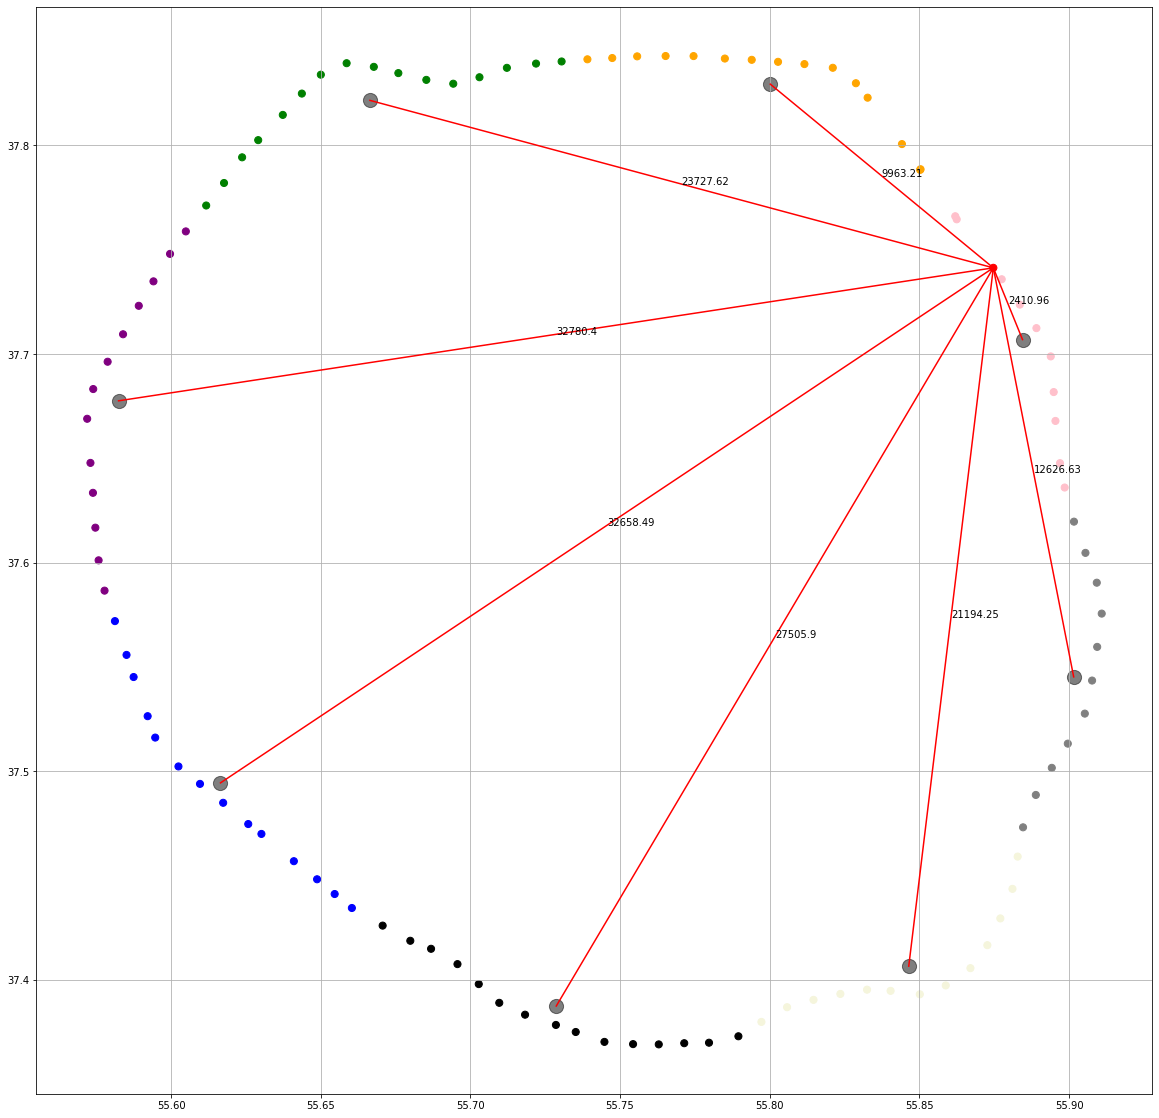

In [103]:
res = mkad(dict_test)

In [104]:
res[4][0]

##### Check the district

In [97]:
def check_distr(obj):
    js = open("Москва.js", "r", encoding='utf-8').readlines()[:2]

    distrs = json.loads(js[0][re.search('"features', str(js)).end():-1])
    
    for distr in distrs:
        df_distr = pd.DataFrame(distr['geometry']['coordinates'][0], columns=['Longitude', 'Latitude'])
        if is_inside(obj, df_distr):
            return distr['properties']['description']
    return 'Unknown'

In [102]:
check_distr(dict_test)

'Граница Москвы'

##### Main functionality

In [80]:
def adress_to_coord(adress):
    '''
    Convert adress to longitude and 
    latitude (return tuple (long, lat))
    '''
    url = "http://search.maps.sputnik.ru/search"

    payload = ""
    headers = {'cookie': 'session_id=CvLubV%2BJmi5SZTO4igJwAg%3D%3D'}

    querystring = {"q": adress}
    response = requests.request(
        "GET", url, data=payload, headers=headers, params=querystring)
    data = json.loads(response.text)

    try:
        return [data['result'][0]['position']['lat'], data['result'][0]['position']['lon']]
    except IndexError:
        return []


In [45]:
def walking_dist__time(la1, lo1, la2, lo2, dist_time):
    '''
    Returns walking distance or time
    '''
    r_text = requests.get('http://192.168.1.89:8989/route?point={},{}&point={},{}&vehicle=foot'.format(
        la1,
        lo1,
        la2,
        lo2)
    ).text

    data = json.loads(r_text)
    if dist_time:
        return round(data['paths'][0]['time'] / 60000, 2)
    else:
        return round(data['paths'][0]['distance'], 2)

In [46]:
def street_map_plotting(is_current_cluster, cdv, colors, oc):
    '''
    Creating a street map with markers of 
    clusters (all clusters or only object's cluster)
    '''
    import folium

    street_map = folium.Map(
        location=[cdv['Latitude'].mean(
        ), cdv['Longitude'].mean()],
        zoom_start=10
    )

    if is_current_cluster:
        for _, obj_m in cdv.iterrows():
            if obj_m['cluster_label'] in {oc, 8}:
                folium.Marker(
                    location=[(obj_m['Latitude']), obj_m['Longitude']],
                    popup=obj_m['Title'],
                    icon=folium.Icon(color=colors[obj_m['cluster_label']])
                ).add_to(street_map)
    else:
        for _, obj_m in cdv.iterrows():
            folium.Marker(
                location=[(obj_m['Latitude']), obj_m['Longitude']],
                popup=obj_m['Title'],
                icon=folium.Icon(color=colors[obj_m['cluster_label']])
            ).add_to(street_map)
    return street_map

In [47]:
def walking_dist__time__title(obj, poi_s):
    '''
    Returns walking dist, time, title of
    place of interest
    '''
    from geopy.distance import geodesic
    from kneed import KneeLocator
    import plotly.graph_objects as go
    from sklearn.cluster import KMeans

    # Sample from data with id for merge ---------------------------------------------------------------------------------------------------
    poi_s['parcelid'] = pd.Series(range(poi_s.shape[0]))
    X = poi_s.loc[:, ['parcelid', 'Latitude', 'Longitude']]

    # Searching optimal nuber of clusters --------------------------------------------------------------------------------------------------
    # K_clusters = range(1, 20)
    # kmeans = [KMeans(n_clusters=i) for i in K_clusters]
    # lat_long = X[['Latitude', 'Longitude']]
    # score = [kmeans[i].fit(lat_long).score(lat_long)
    #         for i in range(len(kmeans))]
    # kn = KneeLocator(K_clusters, score, curve='concave',
    #                 direction='increasing').knee

    # Visualize the Results
    # centers = kmeans.cluster_centers_  # Coordinates of cluster centers.
    # labels = kmeans.predict(X[['Latitude', 'Longitude']])  # Labels of each point

    # X.plot.scatter(x = 'Latitude', y = 'Longitude', c=labels, s=50, cmap='viridis')
    # plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

    # Model building and predicting --------------------------------------------------------------------------------------------------------
    # (kn instead of 8, when searching optimal nuber of clusters runs)
    kmeans = KMeans(n_clusters=8, init='k-means++')
    kmeans.fit(X[['Latitude', 'Longitude']])
    X['cluster_label'] = kmeans.predict(X[['Latitude', 'Longitude']])

    # Merging with general data ------------------------------------------------------------------------------------------------------------
    X = X[['parcelid', 'cluster_label']]
    clustered_data = poi_s.merge(X, left_on='parcelid', right_on='parcelid')

    clustered_data.drop(columns='parcelid', inplace=True)

    # Visualize the Results (without searching optimal number of clusters) -----------------------------------------------------------------
    clustered_data_for_visualisation = clustered_data.append(
        {'Longitude': obj['Longitude'], 'Latitude': obj['Latitude'], 'Title': 'Property object', 'cluster_label': 8}, ignore_index=True)

    clst_colors = {0: 'gray', 1: 'green', 2: 'blue', 3: 'beige',
                   4: 'pink', 5: 'purple', 6: 'orange', 7: 'black', 8: 'red'}

    plt.figure(figsize=(20, 20))
    scatter = plt.scatter(clustered_data_for_visualisation['Latitude'], clustered_data_for_visualisation['Longitude'],
                          c=clustered_data_for_visualisation['cluster_label'].replace(clst_colors), s=50, cmap='viridis')
    plt.grid(True)
    centers = kmeans.cluster_centers_
    plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

    obj_la = float(obj['Latitude'][:1])
    obj_lo = float(obj['Longitude'][:1])

    for lat, lon in zip(centers[:, 0], centers[:, 1]):
        plt.plot([lat, obj_la], [lon, obj_lo], color='r')
        plt.annotate(round(geodesic([obj_la, obj_lo], [lat, lon]).meters, 2),
                     xy=(np.mean([lat, obj_la]), np.mean([lon, obj_lo])))

    obj_clst = kmeans.predict(obj[['Latitude', 'Longitude']])[
        0]
    street_map = (street_map_plotting(False, clustered_data_for_visualisation, clst_colors, obj_clst),
                  street_map_plotting(True, clustered_data_for_visualisation, clst_colors, obj_clst))

    # Getting cluster of the object --------------------------------------------------------------------------------------------------------
    clustered_data = clustered_data[clustered_data['cluster_label'] == obj_clst]

    # Adds a column with walking distance to object in poi_s set ---------------------------------------------------------------------------
    clustered_data['dist_to_obj_walking'] = list(
        map(
            lambda a: walking_dist__time(
                obj_la,
                obj_lo, a[0], a[1], False),
            np.array(clustered_data[['Latitude', 'Longitude']])
        )
    )

    min_dist = min(
        clustered_data['dist_to_obj_walking']
    )

    return clustered_data[['Title', 'Latitude', 'Longitude', 'dist_to_obj_walking']][clustered_data['dist_to_obj_walking'] == min_dist], street_map

In [48]:
def nearest_poi(obj, poi_s):  # obj - DataFrame [1:2]; poi_s - DataFrame [:3]
    '''
    Returns distance from current porperty (obj)
    to point of interest (poi)
    (meters), walking distance (meters), amount of time to poi (minutes), title of poi,
    street map with markers (folium),
    object latitude, longitude
    poi latitude, longitude
    '''
    from geopy.distance import geodesic

    walking_dist__la__lo__time__title, street_map = walking_dist__time__title(
        obj, poi_s)

    obj_la = float(obj['Latitude'][:1])
    obj_lo = float(obj['Longitude'][:1])
    poi_la = float(walking_dist__la__lo__time__title['Latitude'][:1])
    poi_lo = float(walking_dist__la__lo__time__title['Longitude'][:1])

    dist = round(geodesic([obj_la, obj_lo],
                          [poi_la, poi_lo]).meters, 2)

    time = walking_dist__time(obj_la, obj_lo, poi_la, poi_lo, True)

    return dist, walking_dist__la__lo__time__title['dist_to_obj_walking'][:1], time, [obj_la, obj_lo], [poi_la, poi_lo], walking_dist__la__lo__time__title['Title'][:1], street_map

In [28]:
dict_test = pd.DataFrame(
    {'Longitude': 37.741261, 'Latitude': 55.874698}, index=[1, ])

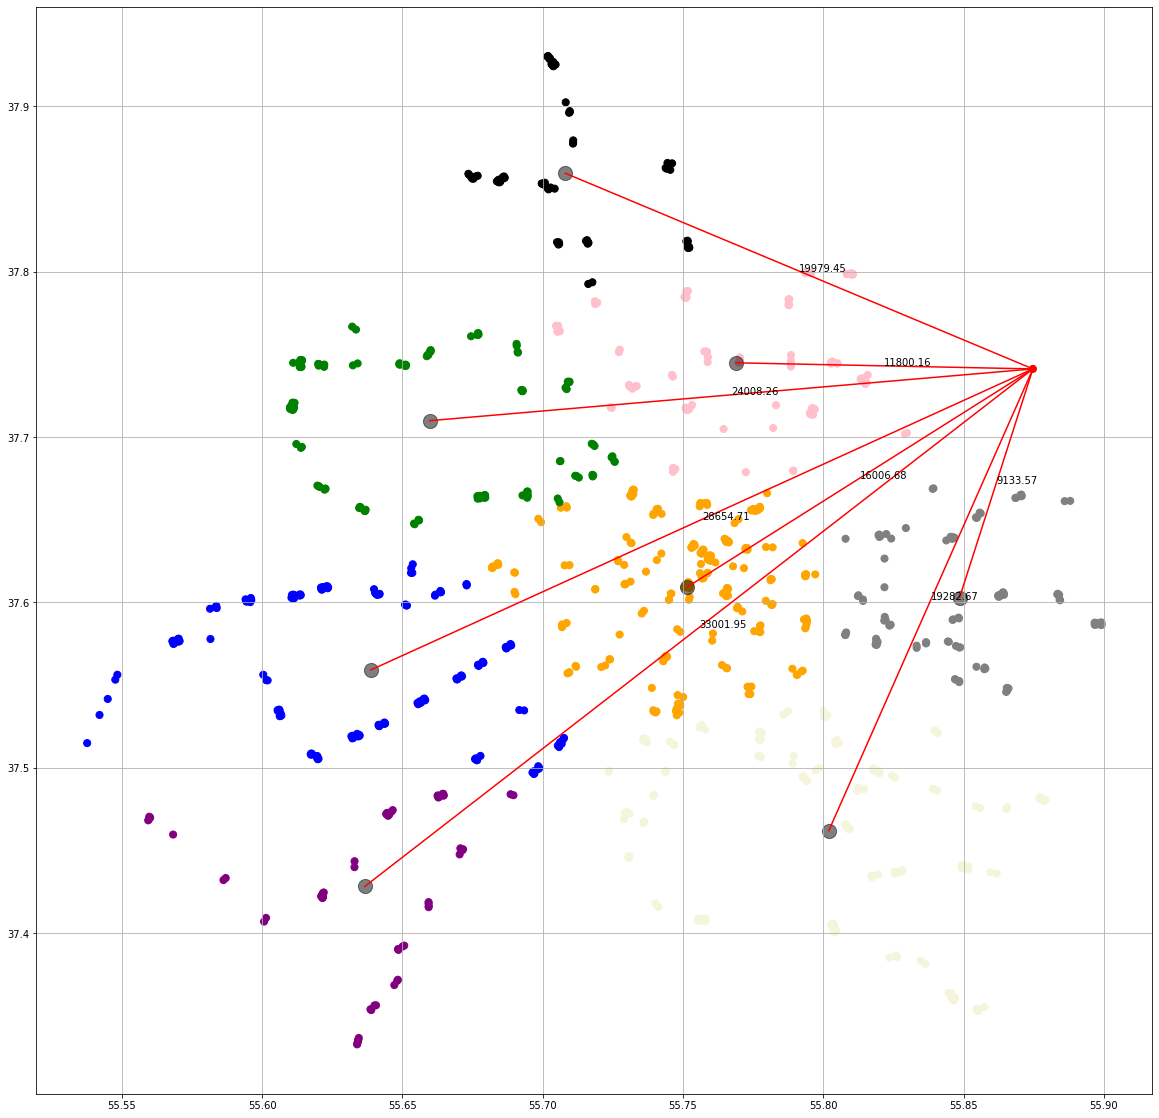

In [50]:
res = walking_dist__time__title(dict_test, df_subways)

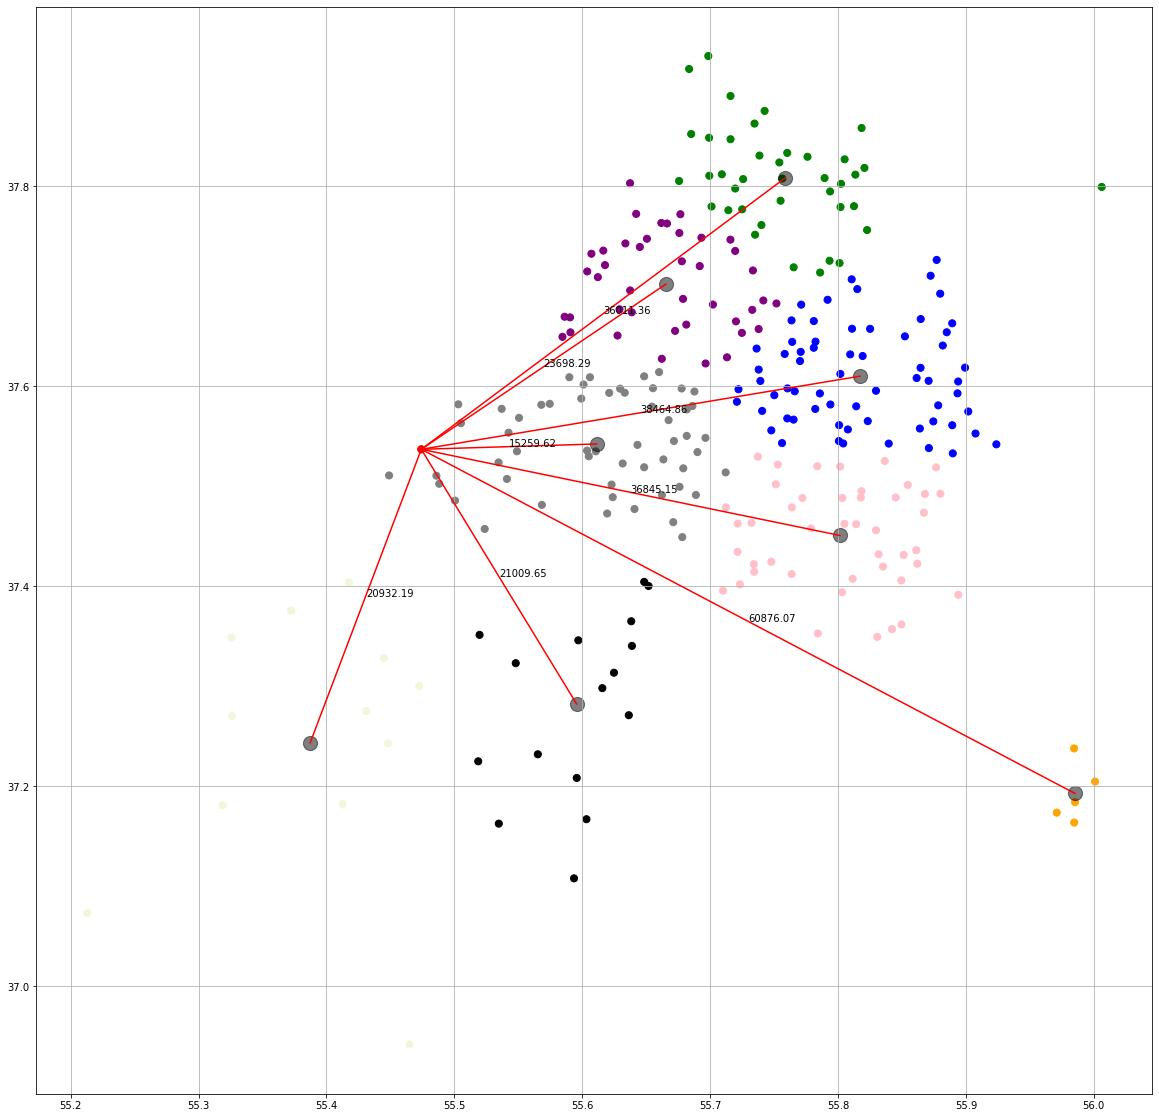

In [73]:
res = nearest_poi(dict_test, df_polyclinics)

In [74]:
res[4][0]

In [75]:
res[4][1]